In [4]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [5]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE =128
EPOCHS = 10

In [12]:
print('Loading word vectors....')
word2vec = {}
with open('glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
#f=open("glove.6B.100d.txt", "r", encoding="utf8")
#contents = f.read()
print('Found %s word vectors' % len(word2vec))

Loading word vectors....
Found 400000 word vectors


In [14]:
print('Loading in comments...')
train = pd.read_csv('train.csv')
sentences = train['comment_text'].fillna('DUMMY_VALUE').values
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
targets = train[labels].values

Loading in comments...


In [15]:
print('max sequence length:', max(len(s) for s in sentences))
print('min sequence length:', min(len(s) for s in sentences))
s = sorted(len(s) for s in sentences)
print('median sequence length', s[len(s) // 2])

max sequence length: 5000
min sequence length: 6
median sequence length 205


In [16]:
#convert sentences into integers

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [17]:
#word to integer mapping

word2idx = tokenizer.word_index
print('Found %s unique tokens' % len(word2idx))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('shape of data tensor:', data.shape)

Found 210337 unique tokens
shape of data tensor: (159571, 100)


In [18]:
#Embedding Matrix
print('Filling pre-trained embeddings....')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector=word2vec.get(word)
        if embedding_vector is not None:
            #words not found in embedding indes will be all zeros
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings....


In [19]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [20]:
print('Building model....')
input_ = Input(shape=(MAX_SEQUENCE_LENGTH, ))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(labels), activation='sigmoid')(x)

Building model....


In [21]:
model = Model(input_, output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print('Training model....')
r = model.fit(data, targets, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT)

Training model....
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 120s 938us/step - loss: 0.0843 - acc: 0.9732 - val_loss: 0.0740 - val_acc: 0.9752
Epoch 2/10
127656/127656 [==============================] - 137s 1ms/step - loss: 0.0675 - acc: 0.9772 - val_loss: 0.0680 - val_acc: 0.9768
Epoch 3/10
127656/127656 [==============================] - 134s 1ms/step - loss: 0.0632 - acc: 0.9783 - val_loss: 0.0730 - val_acc: 0.9750
Epoch 4/10
127656/127656 [==============================] - 133s 1ms/step - loss: 0.0603 - acc: 0.9791 - val_loss: 0.0771 - val_acc: 0.9744
Epoch 5/10
127656/127656 [==============================] - 133s 1ms/step - loss: 0.0581 - acc: 0.9797 - val_loss: 0.0669 - val_acc: 0.9779
Epoch 6/10
127656/127656 [==============================] - 132s 1ms/step - loss: 0.0568 - acc: 0.9802 - val_loss: 0.0766 - val_acc: 0.9752
Epoch 7/10
127656/127656 [==============================] - 136s 1ms/step - loss: 0.0552

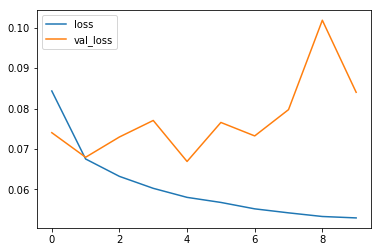

In [22]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

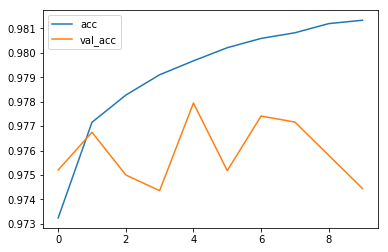

In [23]:
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [24]:
result = model.predict(data)
result

array([[  3.21314086e-09,   7.85868492e-29,   9.35628460e-14,
          4.56467186e-34,   3.18551405e-14,   3.16055923e-23],
       [  1.32152950e-03,   1.42599388e-09,   1.33258160e-04,
          2.03258765e-09,   1.03445025e-04,   2.44940111e-07],
       [  1.88389458e-02,   5.28574219e-07,   3.83181730e-03,
          7.40894393e-07,   2.90048937e-03,   1.75883943e-05],
       ..., 
       [  9.88315853e-12,   0.00000000e+00,   1.67287272e-21,
          0.00000000e+00,   2.36656252e-23,   0.00000000e+00],
       [  1.30454535e-02,   9.89293426e-07,   2.70124828e-03,
          1.92777429e-06,   2.34483392e-03,   4.64449367e-05],
       [  1.43907502e-01,   4.14148235e-05,   8.86116084e-03,
          9.54113784e-04,   1.66346002e-02,   4.60735848e-03]], dtype=float32)